Parameters of the largest detected circle:
Center: (107, 256)
Radius: 16
Sigma value: 2.5


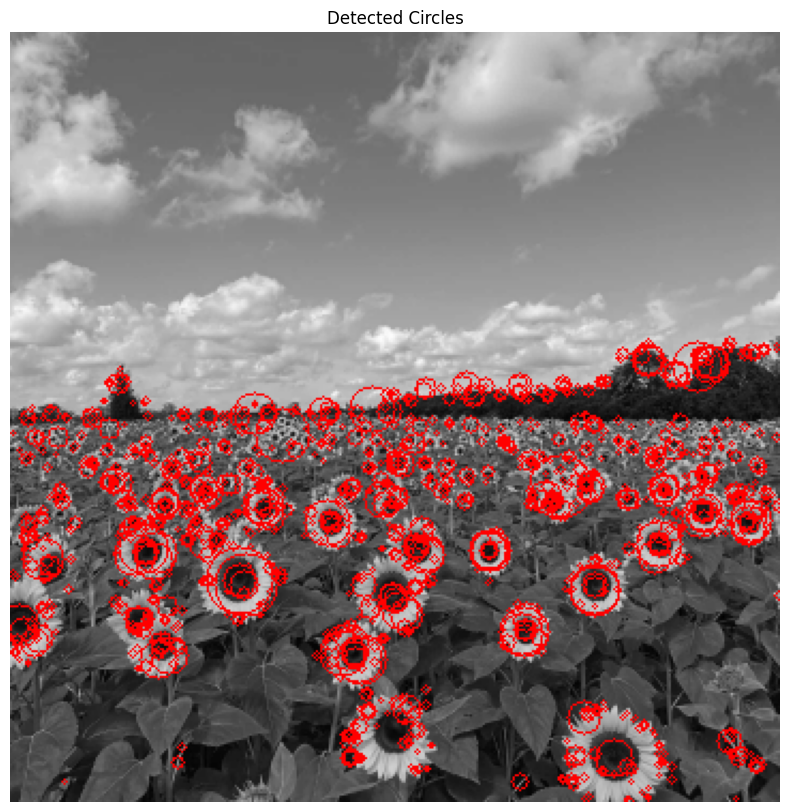

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image you want to process
image_to_analyze = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
gray_image = cv2.cvtColor(image_to_analyze, cv2.COLOR_BGR2GRAY)

min_sigma_value = 0.5
max_sigma_value = 2.5
sigma_steps = 5
detection_threshold = 0.35
detected_circles = []

for current_sigma in np.linspace(min_sigma_value, max_sigma_value, sigma_steps):
    smoothed_image = cv2.GaussianBlur(gray_image, (0, 0), current_sigma)
    laplacian_image = cv2.Laplacian(smoothed_image, cv2.CV_64F)
    abs_laplacian = np.abs(laplacian_image)
    blob_mask = abs_laplacian > detection_threshold * abs_laplacian.max()

    contours, _ = cv2.findContours(blob_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if len(contour) >= 5:
            (circle_center, circle_radius) = cv2.minEnclosingCircle(contour)
            circle_center = (int(circle_center[0]), int(circle_center[1]))
            circle_radius = int(circle_radius)
            detected_circles.append((circle_center, circle_radius, current_sigma))

detected_circles.sort(key=lambda x: -x[1])
largest_detected_circle = detected_circles[0]
center_coordinates, circle_radius, sigma_value = largest_detected_circle

print("Parameters of the largest detected circle:")
print(f"Center: {center_coordinates}")
print(f"Radius: {circle_radius}")
print(f"Sigma value: {sigma_value}")

# Set the line thickness for drawing circles
circle_line_thickness = 1

# Draw all detected circles on a copy of the original image
result_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
for detected_circle in detected_circles:
    (circle_center, circle_radius, _) = detected_circle
    cv2.circle(result_image, circle_center, circle_radius, (0, 0, 255), circle_line_thickness)

# Display the grayscale image with detected circles using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected Circles')
plt.show()


Question 02

Number of inliers in the line: 16
Parameters of the estimated line:
a: 0.7080986693010423
b: 0.7061134997534697
d: 1.5303717301982513
Number of remnant points: 84
Number of inliers in the circle: 16
Parameters of the estimated circle:
x_center: 2.0388812056906938
y_center: 2.905374551155992
radius: 9.971739443086292


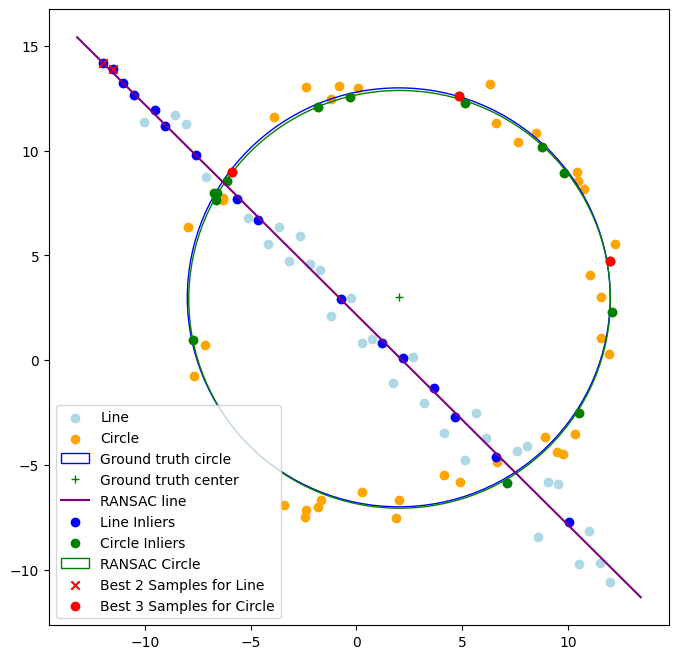

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Ensure reproducibility
np.random.seed(1)

# Number of data points
N = 100
half_n = N // 2

# Circle parameters
radius = 10
center_x, center_y = 2, 3
noise_scale = radius / 16

# Generate points for the circle
circle_angles = np.random.uniform(0, 2 * np.pi, half_n)
circle_noise = noise_scale * np.random.randn(half_n)
circle_x = center_x + (radius + circle_noise) * np.cos(circle_angles)
circle_y = center_y + (radius + circle_noise) * np.sin(circle_angles)

circle_points = np.column_stack((circle_x, circle_y))

# Line parameters
line_slope = -1.0
line_intercept = 2.0
line_noise_scale = 1.0

# Generate points for the line
line_x = np.linspace(-12, 12, half_n)
line_y = line_slope * line_x + line_intercept + line_noise_scale * np.random.randn(half_n)

line_points = np.column_stack((line_x, line_y))

# Combine points from the circle and line
data_points = np.vstack((circle_points, line_points))

# Create a scatter plot of noisy data points, ground truth line, and circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(line_points[:, 0], line_points[:, 1], color='lightblue', label='Line')
ax.scatter(circle_points[:, 0], circle_points[:, 1], color='orange', label='Circle')
ground_truth_circle = plt.Circle((center_x, center_y), radius, color='blue', fill=False, label='Ground truth circle')
ax.add_artist(ground_truth_circle)
ax.plot(center_x, center_y, '+g', label='Ground truth center')

# Define a function to calculate the line equation from two points
def calculate_line_equation(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x ** 2 + delta_y ** 2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint


def ransac_line_fitting(data, iterations, distance_threshold, min_inliers):
    best_model = None
    best_inliers = []

    for _ in range(iterations):
        sample_indices = np.random.choice(len(data), 2, replace=False)
        x1, y1 = data[sample_indices[0]]
        x2, y2 = data[sample_indices[1]]

        a, b, d = calculate_line_equation(x1, y1, x2, y2)

        magnitude = np.sqrt(a ** 2 + b ** 2)
        a /= magnitude
        b /= magnitude

        distances = np.abs(a * data[:, 0] + b * data[:, 1] - d)
        inliers = np.where(distances < distance_threshold)[0]

        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers

    return best_model, best_inliers

# RANSAC parameters for line fitting
ransac_iterations_line = 10000
ransac_threshold_line = 0.15
ransac_min_inliers_line = 15

# Estimate the line using RANSAC
best_line_params, line_inlier_indices = ransac_line_fitting(line_points, ransac_iterations_line, ransac_threshold_line, ransac_min_inliers_line)

print("Number of inliers in the line:", len(line_inlier_indices))
print("Parameters of the estimated line:")
print(f"a: {best_line_params[0]}")
print(f"b: {best_line_params[1]}")
print(f"d: {best_line_params[2]}")

# Calculate the circle equation from three points
def calculate_circle_equation(x1, y1, x2, y2, x3, y3):
    mid_x1, mid_y1 = (x1 + x2) / 2, (y1 + y2) / 2
    mid_x2, mid_y2 = (x2 + x3) / 2, (y2 + y3) / 2

    if y2 - y1 == 0:
        slope1 = 0
    else:
        slope1 = (x2 - x1) / (y2 - y1)

    if y3 - y2 == 0:
        slope2 = 0
    else:
        slope2 = (x3 - x2) / (y3 - y2)

    circle_center_x = (slope1 * mid_x1 - slope2 * mid_x2 + mid_y2 - mid_y1) / (slope1 - slope2)
    circle_center_y = -slope1 * (circle_center_x - mid_x1) + mid_y1

    radius = np.sqrt((x1 - circle_center_x) ** 2 + (y1 - circle_center_y) ** 2)

    return circle_center_x, circle_center_y, radius

# RANSAC to fit a circle


def ransac_circle_fitting(data, iterations, distance_threshold, min_inliers):
    best_model = None
    best_inliers = []

    for _ in range(iterations):
        sample_indices = np.random.choice(len(data), 3, replace=False)
        x1, y1 = data[sample_indices[0]]
        x2, y2 = data[sample_indices[1]]
        x3, y3 = data[sample_indices[2]]

        circle_center_x, circle_center_y, radius = calculate_circle_equation(x1, y1, x2, y2, x3, y3)

        errors = np.abs(np.sqrt((data[:, 0] - circle_center_x) ** 2 + (data[:, 1] - circle_center_y) ** 2) - radius)
        inliers = np.where(errors < distance_threshold)[0]

        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (circle_center_x, circle_center_y, radius)
                best_inliers = inliers

    return best_model, best_inliers

# RANSAC parameters for circle fitting
ransac_iterations_circle = 10000
ransac_threshold_circle = 0.2
ransac_min_inliers_circle = 15

# Identify the remaining points (not explained by the line)
remaining_indices = [i for i in range(len(data_points)) if i not in line_inlier_indices]
remaining_points = data_points[remaining_indices]

print("Number of remnant points:", len(remaining_points))
# Estimate the circle using RANSAC
best_circle_params, circle_inlier_indices = ransac_circle_fitting(remaining_points, ransac_iterations_circle, ransac_threshold_circle, ransac_min_inliers_circle)

print("Number of inliers in the circle:", len(circle_inlier_indices))
print("Parameters of the estimated circle:")
print(f"x_center: {best_circle_params[0]}")
print(f"y_center: {best_circle_params[1]}")
print(f"radius: {best_circle_params[2]}")

# Plot the results

# Plot the estimated line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_params[0] * x_range + best_line_params[2]) / best_line_params[1]
plt.plot(x_range, y_range, label='RANSAC line', color='purple')

ax.scatter(line_points[line_inlier_indices, 0], line_points[line_inlier_indices, 1], color='blue', label='Line Inliers')

best_line_sample_indices = line_inlier_indices[:2]
best_line_samples = line_points[best_line_sample_indices]

ax.scatter(remaining_points[circle_inlier_indices, 0], remaining_points[circle_inlier_indices, 1], color='g', label='Circle Inliers')

circle_center_x, circle_center_y, circle_radius = best_circle_params
circle_estimated = plt.Circle((circle_center_x, circle_center_y), circle_radius, color='g', fill=False, label='RANSAC Circle')
ax.add_artist(circle_estimated)

best_circle_sample_indices = circle_inlier_indices[:3]
best_circle_samples = remaining_points[best_circle_sample_indices]

ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')

plt.legend()
plt.show()


Question 03

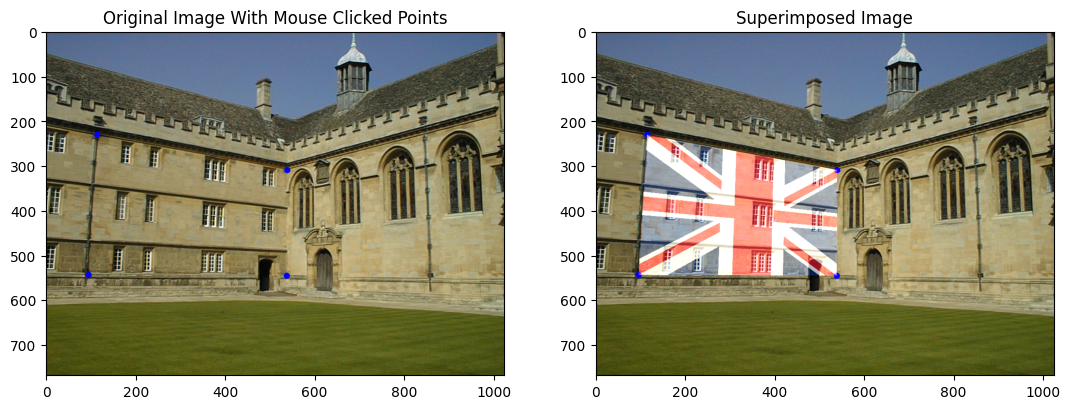

In [1]:
#Q3
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

counter = 0 # Counter to keep track of the number of points clicked
number_of_points = 4 # Maximum number of points to be clicked
building_points = np.empty((number_of_points,2)) # Empty array to store the points clicked

# Load the building and flag images
building = cv.imread('architectural_image.jpg', cv.IMREAD_COLOR)
UK_flag = cv.imread('flag_image.png', cv.IMREAD_COLOR)

# Define mouse callback function to get the mouse points of the building image
def draw_circle(event, x, y, flags, img): # Event is the type of mouse event, x and y are the coordinates of the mouse pointer, flags is the additional flags associated with the image, img is the user-defined building that is passed
    global counter
    if event == cv.EVENT_LBUTTONDOWN: # Checks if left mouse button is pressed
        cv.circle(img, (x,y), 7, (255, 0, 0), -1) # Draws a circle at the mouse pointer, -1 means the circle should be filled, (255, 0, 0) is the blue color of the circle in BGR
        building_points[counter] = (x,y) 
        counter += 1

# Getting the mouse points of the building image
cv.namedWindow('Base Image', cv.WINDOW_AUTOSIZE) # Creates a window with the name 'Base Image'
cv.setMouseCallback('Base Image', draw_circle, building) # Calls the callback function when a mouse event occurs, building is the user-defined parameter that is passed
while(True):
    cv.imshow('Base Image', building) 
    if counter == number_of_points: # Checks if the number of points clicked is equal to the maximum number of points
        break
    if cv.waitKey(20) & 0xFF == 27: # Checks if the 'Esc' key is pressed
        break

# Define the corresponding points on the flag image
flag_points = np.array([[0, 0], [UK_flag.shape[1], 0], [UK_flag.shape[1], UK_flag.shape[0]], [0, UK_flag.shape[0]]], dtype=np.float32)

# Find the homography matrix
homography_matrix, _ = cv.findHomography(flag_points, building_points)

# Warp the flag image to match the the building points using the homography matrix
flag_warped = cv.warpPerspective(UK_flag, homography_matrix, (building.shape[1], building.shape[0]))

# Blend the two images
blended_image = cv.addWeighted(building, 1, flag_warped, 0.7, 0)

# Display the result using OpenCV
cv.imshow('Superimposed Image', blended_image)
cv.imwrite('superimposed_flag_building.png', blended_image) # Save the image
cv.waitKey(0)
cv.destroyAllWindows()

# Display the mouse clicked original and superimposed image using matplotlib
plt.figure(figsize=(13, 13)), plt.subplot(1,2,1), plt.imshow(cv.cvtColor(building, cv.COLOR_BGR2RGB)) # The last parameter in plt.subplot() is the current index of the subplot
plt.title('Original Image With Mouse Clicked Points')
plt.subplot(1,2,2), plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB)), plt.title('Superimposed Image')
plt.show()

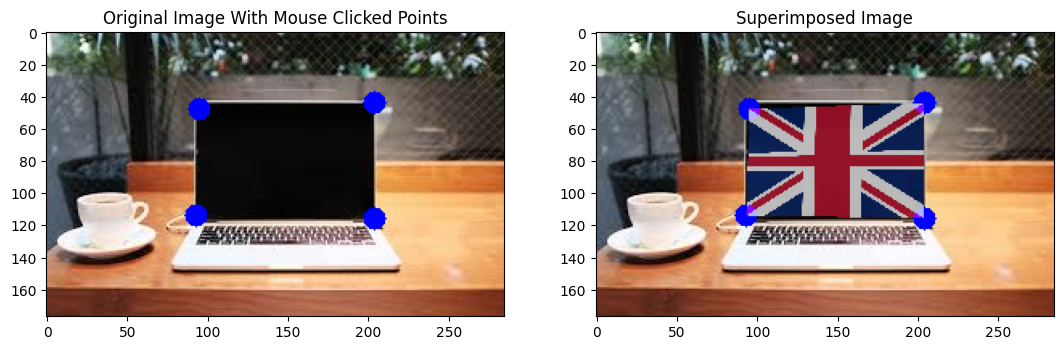

In [13]:
#Q3
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

counter = 0 # Counter to keep track of the number of points clicked
number_of_points = 4 # Maximum number of points to be clicked
building_points = np.empty((number_of_points,2)) # Empty array to store the points clicked

# Load the building and flag images
building = cv.imread('laptop.jpeg', cv.IMREAD_COLOR)
UK_flag = cv.imread('flag_image.png', cv.IMREAD_COLOR)

# Define mouse callback function to get the mouse points of the building image
def draw_circle(event, x, y, flags, img): # Event is the type of mouse event, x and y are the coordinates of the mouse pointer, flags is the additional flags associated with the image, img is the user-defined building that is passed
    global counter
    if event == cv.EVENT_LBUTTONDOWN: # Checks if left mouse button is pressed
        cv.circle(img, (x,y), 7, (255, 0, 0), -1) # Draws a circle at the mouse pointer, -1 means the circle should be filled, (255, 0, 0) is the blue color of the circle in BGR
        building_points[counter] = (x,y) 
        counter += 1

# Getting the mouse points of the building image
cv.namedWindow('Base Image', cv.WINDOW_AUTOSIZE) # Creates a window with the name 'Base Image'
cv.setMouseCallback('Base Image', draw_circle, building) # Calls the callback function when a mouse event occurs, building is the user-defined parameter that is passed
while(True):
    cv.imshow('Base Image', building) 
    if counter == number_of_points: # Checks if the number of points clicked is equal to the maximum number of points
        break
    if cv.waitKey(20) & 0xFF == 27: # Checks if the 'Esc' key is pressed
        break

# Define the corresponding points on the flag image
flag_points = np.array([[0, 0], [UK_flag.shape[1], 0], [UK_flag.shape[1], UK_flag.shape[0]], [0, UK_flag.shape[0]]], dtype=np.float32)

# Find the homography matrix
homography_matrix, _ = cv.findHomography(flag_points, building_points)

# Warp the flag image to match the the building points using the homography matrix
flag_warped = cv.warpPerspective(UK_flag, homography_matrix, (building.shape[1], building.shape[0]))

# Blend the two images
blended_image = cv.addWeighted(building, 1, flag_warped, 0.7, 0)

# Display the result using OpenCV
cv.imshow('Superimposed Image', blended_image)
cv.imwrite('superimposed_flag_building.png', blended_image) # Save the image
cv.waitKey(0)
cv.destroyAllWindows()

# Display the mouse clicked original and superimposed image using matplotlib
plt.figure(figsize=(13, 13)), plt.subplot(1,2,1), plt.imshow(cv.cvtColor(building, cv.COLOR_BGR2RGB)) # The last parameter in plt.subplot() is the current index of the subplot
plt.title('Original Image With Mouse Clicked Points')
plt.subplot(1,2,2), plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB)), plt.title('Superimposed Image')
plt.show()

Question 04

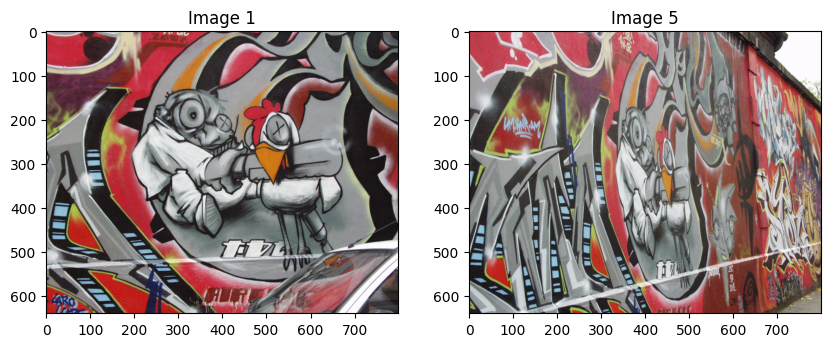

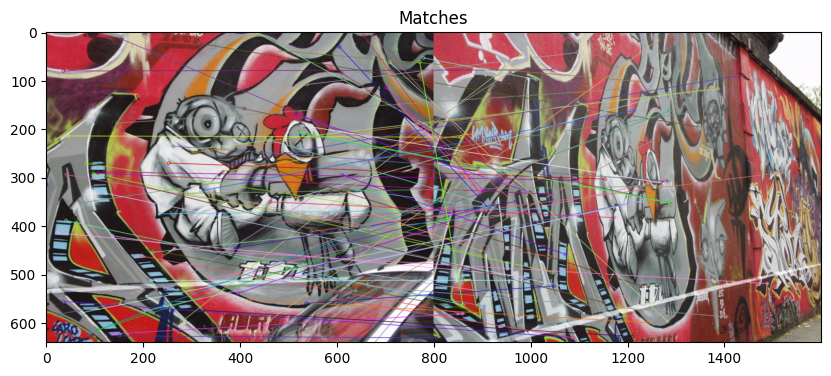

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('graf/img1.ppm', cv2.IMREAD_ANYCOLOR)
img5 = cv2.imread('graf/img5.ppm', cv2.IMREAD_ANYCOLOR)

# Plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Image 5')
plt.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
plt.show()

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors in both images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5, None)

# Create a brute-force matcher
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
        pts1.append(keypoints1[m.queryIdx].pt)
        pts2.append(keypoints5[m.trainIdx].pt)

# Draw the matches
match_img = cv2.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Save the image with matches
cv2.imwrite('matches.jpg', match_img)

# Change the image to RGB color space
#match_img = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)

# Plot the image with matches
plt.figure(figsize=(10, 10))
plt.title('Matches')
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

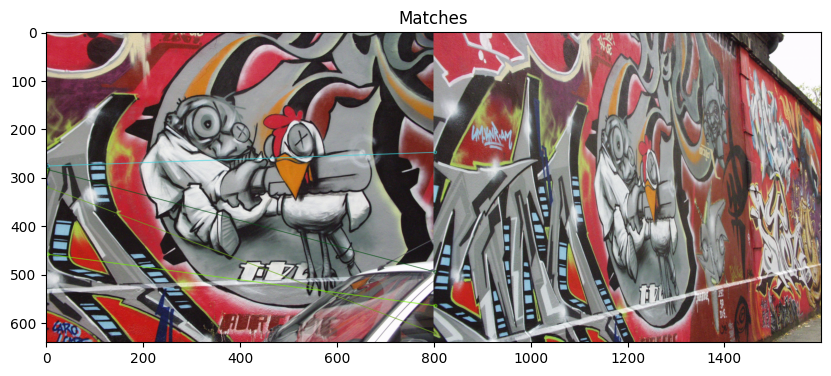

Homography Matrix:
[[-9.92783990e-01 -4.79716074e-01  5.52152279e+02]
 [-7.06350835e-01 -3.38761506e-01  3.89248294e+02]
 [-1.82436928e-03 -8.27491660e-04  1.00000000e+00]]
 
Original Homography Matrix:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


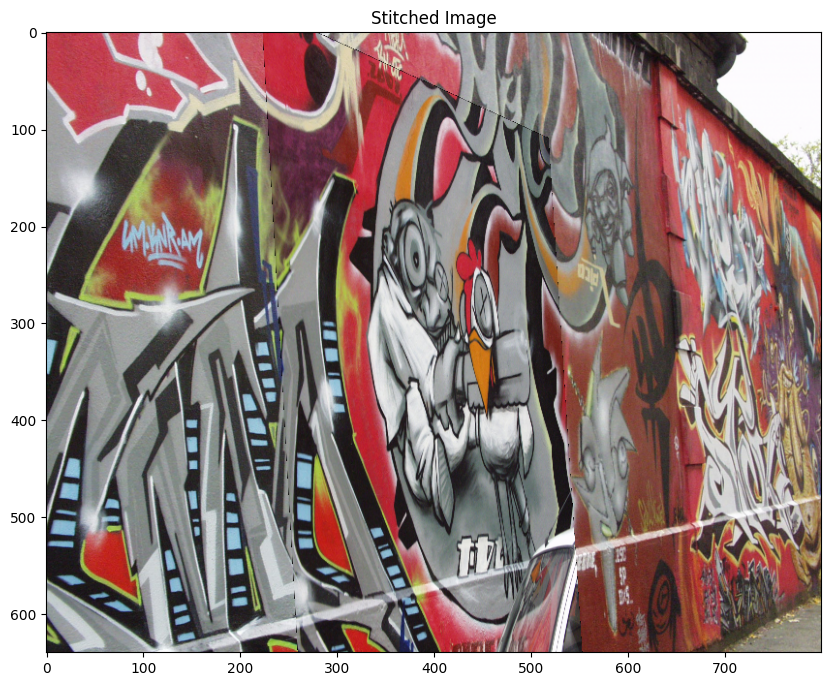

In [12]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def ransac_matching(img1, img2, num_iterations=1000, max_distance=10, min_inliers=100):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors in both images
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img5, None)

    # Create a brute-force matcher
    bf = cv2.BFMatcher()

    best_matches = []  # Store the best matches found by RANSAC
    best_homography = None  # Store the best homography matrix
    best_inliers = []  # Store the inliers of the best model

    for _ in range(num_iterations):
        # Randomly select four matches
        random_matches = random.sample(range(len(keypoints1)), 4)

        # Get the keypoints for the selected matches
        src_pts = np.float32([keypoints1[m].pt for m in random_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m].pt for m in random_matches]).reshape(-1, 1, 2)
        

        # Compute the homography matrix
        homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, max_distance)

        # Transform keypoints from img1 to img2 using the computed homography
        transformed_pts = cv2.perspectiveTransform(src_pts, homography)

        # Calculate the Euclidean distances between transformed and actual keypoints in img2
        distances = np.sqrt(np.sum((dst_pts - transformed_pts) ** 2, axis=2))

        # Count the number of inliers (matches within a certain distance threshold)
        inliers = np.count_nonzero(distances < max_distance)

        # Update if this model has more inliers than the current best
        if inliers > len(best_inliers):
            best_inliers = distances < max_distance
            best_matches = random_matches
            best_homography = homography

        # If we have enough inliers, exit early
        if inliers >= min_inliers:
            break

    # Filter the best matches using inliers
    filtered_matches = [cv2.DMatch(i, i, 0) for i, is_inlier in enumerate(best_inliers) if is_inlier]

    return filtered_matches, best_homography, keypoints1, keypoints2


# Find matching points using custom RANSAC
matches, homography, keypoints1, keypoints2 = ransac_matching(img1, img5)

# Draw the matching points
matched_img = cv2.drawMatches(img1, keypoints1, img5, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show the image with matches
plt.figure(figsize=(10, 10))
plt.title('Matches')
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.show()

print("Homography Matrix:")
print(homography)

print(" ")

# Load homography matrix from file
homography = np.loadtxt(r"graf\H1to5p")

# Print the original homography matrix
print("Original Homography Matrix:")
print(homography)

# Warp img1 onto img5 using the homography
img1_warped = cv2.warpPerspective(img1, homography, (img5.shape[1], img5.shape[0]))

# Create a binary mask of the warped image
_, img1_mask = cv2.threshold(cv2.cvtColor(img1_warped, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)

# Invert the mask to get the region where img1 should be placed
img5_mask = cv2.bitwise_not(img1_mask)

# Blend the two images together
result = cv2.bitwise_and(img5, img5, mask=img5_mask)
result = cv2.add(result, img1_warped)

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.title('Stitched Image')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()
